# Introduction

A harmonic oscillator is a core concept in physics and engineering, referring to
a system that experiences a restoring force directly proportional to its
displacement from equilibrium. The study of harmonic oscillators offers valuable
insights into wave behavior, energy quantization, and resonance, making it an
essential model in both theoretical and applied physics. It shows up in light,
sound, all the way to the motion of a piston driving a shaft in a combustion
engine; in the changing of current flow within the processor of the computer
you're reading this on, being able to predict properties of this motion is
incredibly versatile. This lab homes in on this essential concept while also
looking at other concepts of physics such as position, velocity, acceleration,
forces, energy, magnitude, maximum speed, maximum acceleration, and periods. 


In [9]:
from math import *

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sp

g = 9.80665  # m/s^2

# Problem 1

To find the spring constant, we set the system in equilibrium like so, assuming
both springs are identical:

![Spring-Ball System Equilibrium](force-diagram.png)

From this we get:

$$ F_1 = F_2 \equiv F \qquad F = -kx $$

And since we measure the vertical displacement at equilibrium and not the
displacement in the springs, $x$ must be found from $x_y$:

$$ x = \frac{x_y}{\cos(\theta)} $$

Next, making the sum of forces in the y-direction:

$$ \sum F_y = -2\cos(\theta)kx - mg = 0 $$

$$ -2\cos(\theta)k\left(\frac{x_y}{\cos(\theta)}\right) - mg = 0 $$

$$ -2k x_y - mg = 0 \implies \boxed{k = -\frac{mg}{2x_y}} $$


In [10]:
m = 178  # kg
x_y = -0.85  # m

k = -(m * g) / (2 * x_y)  # N/m
print(f"k: {round(k,3)} N/m (per spring)")

k: 1026.814 N/m (per spring)


Next, the period and frequency of the oscillation can be found like so:

$$ \omega = \sqrt{\frac{k}{m}} \qquad \omega = 2\pi f \qquad T = f^{-1} $$

$$ \boxed{f = \frac{1}{2\pi}\sqrt{\frac{k}{m}}} \qquad \boxed{T = 2\pi\sqrt{\frac{m}{k}}} $$

And the position over time like so:

$$ x(t) = A e^{-\lambda t} \cos(\omega t - \phi) $$

To find the maximum acceleration and velocity, we derive with respect to time
twice like so:

$$ v(t) = -A e^{-\lambda t} \omega \sin(\omega t - \phi) $$

$$ a(t) = -A e^{-\lambda t} \omega^2 \cos(\omega t - \phi) $$

Both of these are multiplied by $e^{-\lambda t}$ for damping. For small values
of $t$, especially for low values of $\lambda$, the damping coefficient
$e^{-\lambda t}$ is approximately 1; the maximum occurs for both functions where
$\sin$ and $\cos$ are 1 too, so:

$$ \boxed{v_{max} \approx -A\sqrt{\frac{k}{m}}} \qquad \boxed{a_{max} \approx -\frac{Ak}{m}} $$

A more precise method would involve finding the critical points of the modified
damping sine wave, but it is not significant enough to justify the calculations.


Predicted frequency: 0.541 Hz
Predicted period: 1.85 seconds
Predicted max velocity: 1.458 m/s
Predicted max acceleration: 4.954 m/s^2


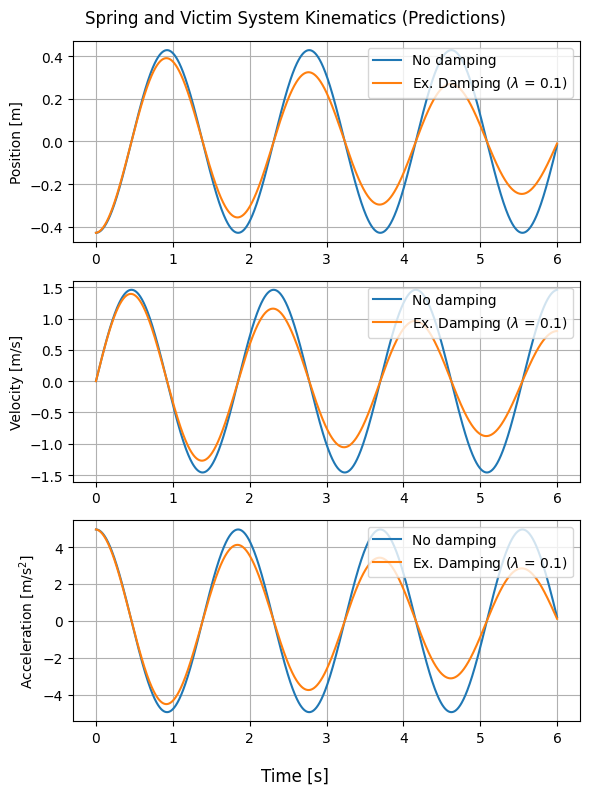

In [11]:
# Loading slo-mo video data
data = np.genfromtxt("video_data.csv", delimiter=",", names=True)
time = data["Time_s"]  # s
distance = data["Distance_m"]  # m

# Parameters
amp = abs(np.max(distance) - np.min(distance)) / 2  # m (can't be predicted since this is an independent variable)
omega = sqrt(2*k / m)  # rad/s (2* since there are two springs)
phase = pi  # rad
lambd = 0.1  # uneducated guess for an example value

# Oscillation data
t = np.linspace(0, 6, 2048)
y = amp * np.cos(omega * t - phase)  # m
v = -amp * omega * np.sin(omega * t - phase) # m/s
a = -(omega**2) * y  # m/s^2 (little hack)

# Damping data
damp = np.exp(-t * lambd)
y_damp, v_damp, a_damp = (
    y * damp,
    v * damp,
    a * damp,
)

# Plotting
fig, axes = plt.subplots(3, figsize=(6, 8))
fig.suptitle("Spring and Victim System Kinematics (Predictions)")
fig.supxlabel("Time [s]")

y_labels = [r"Position [m]", r"Velocity [m/s]", r"Acceleration [m/s$^2$]"]

# Sadly, this is more readable than the Pythonic code :(
for ax, y, y_damp, y_label in zip(axes, [y, v, a], [y_damp, v_damp, a_damp], y_labels):
    ax.plot(t, y, label="No damping")
    ax.plot(t, y_damp, label=r"Ex. Damping ($\lambda$ = " + str(lambd) + ")")
    ax.set_ylabel(y_label)
    ax.grid()
    ax.legend(loc="upper right")

fig.tight_layout()

# Useful data
freq = 1 / (2 * pi) * omega
period = 1 / freq

v_max = amp * omega  # m/s
a_max = amp * (omega**2)  # m/s^2

print(
    f"Predicted frequency: {round(freq,3)} Hz\n"
    f"Predicted period: {round(period,3)} seconds\n"
    f"Predicted max velocity: {round(v_max,3)} m/s\n"
    f"Predicted max acceleration: {round(a_max,3)} m/s^2"
)

## Data

We preformed the experiment by recording the motion over a few minutes (to get
good data for finding the decay coefficient, $\lambda$). Then we transferred the
data to a csv file and plotted it after tracking it on the iPads. Using a Fast
Fourier Transform to efficiently guess the initial parameters, we then used
Scipy to make the fitting function and plot it as well (with the parameters
being what we mainly compare to our estimations).

The equation of best fit is: 0.38410812639749614 * exp(-(0.006107775001355372) * t) * cos(3.434220974372165 * t + (1.9030317747199077)) + (-0.025916874975400274)
Lambda: 0.006107775001355372
Half-life decay: 113.48603712581578 seconds
Actual period: 1.8295809600103736 seconds
Actual frequency: 0.5465732437411953 Hz


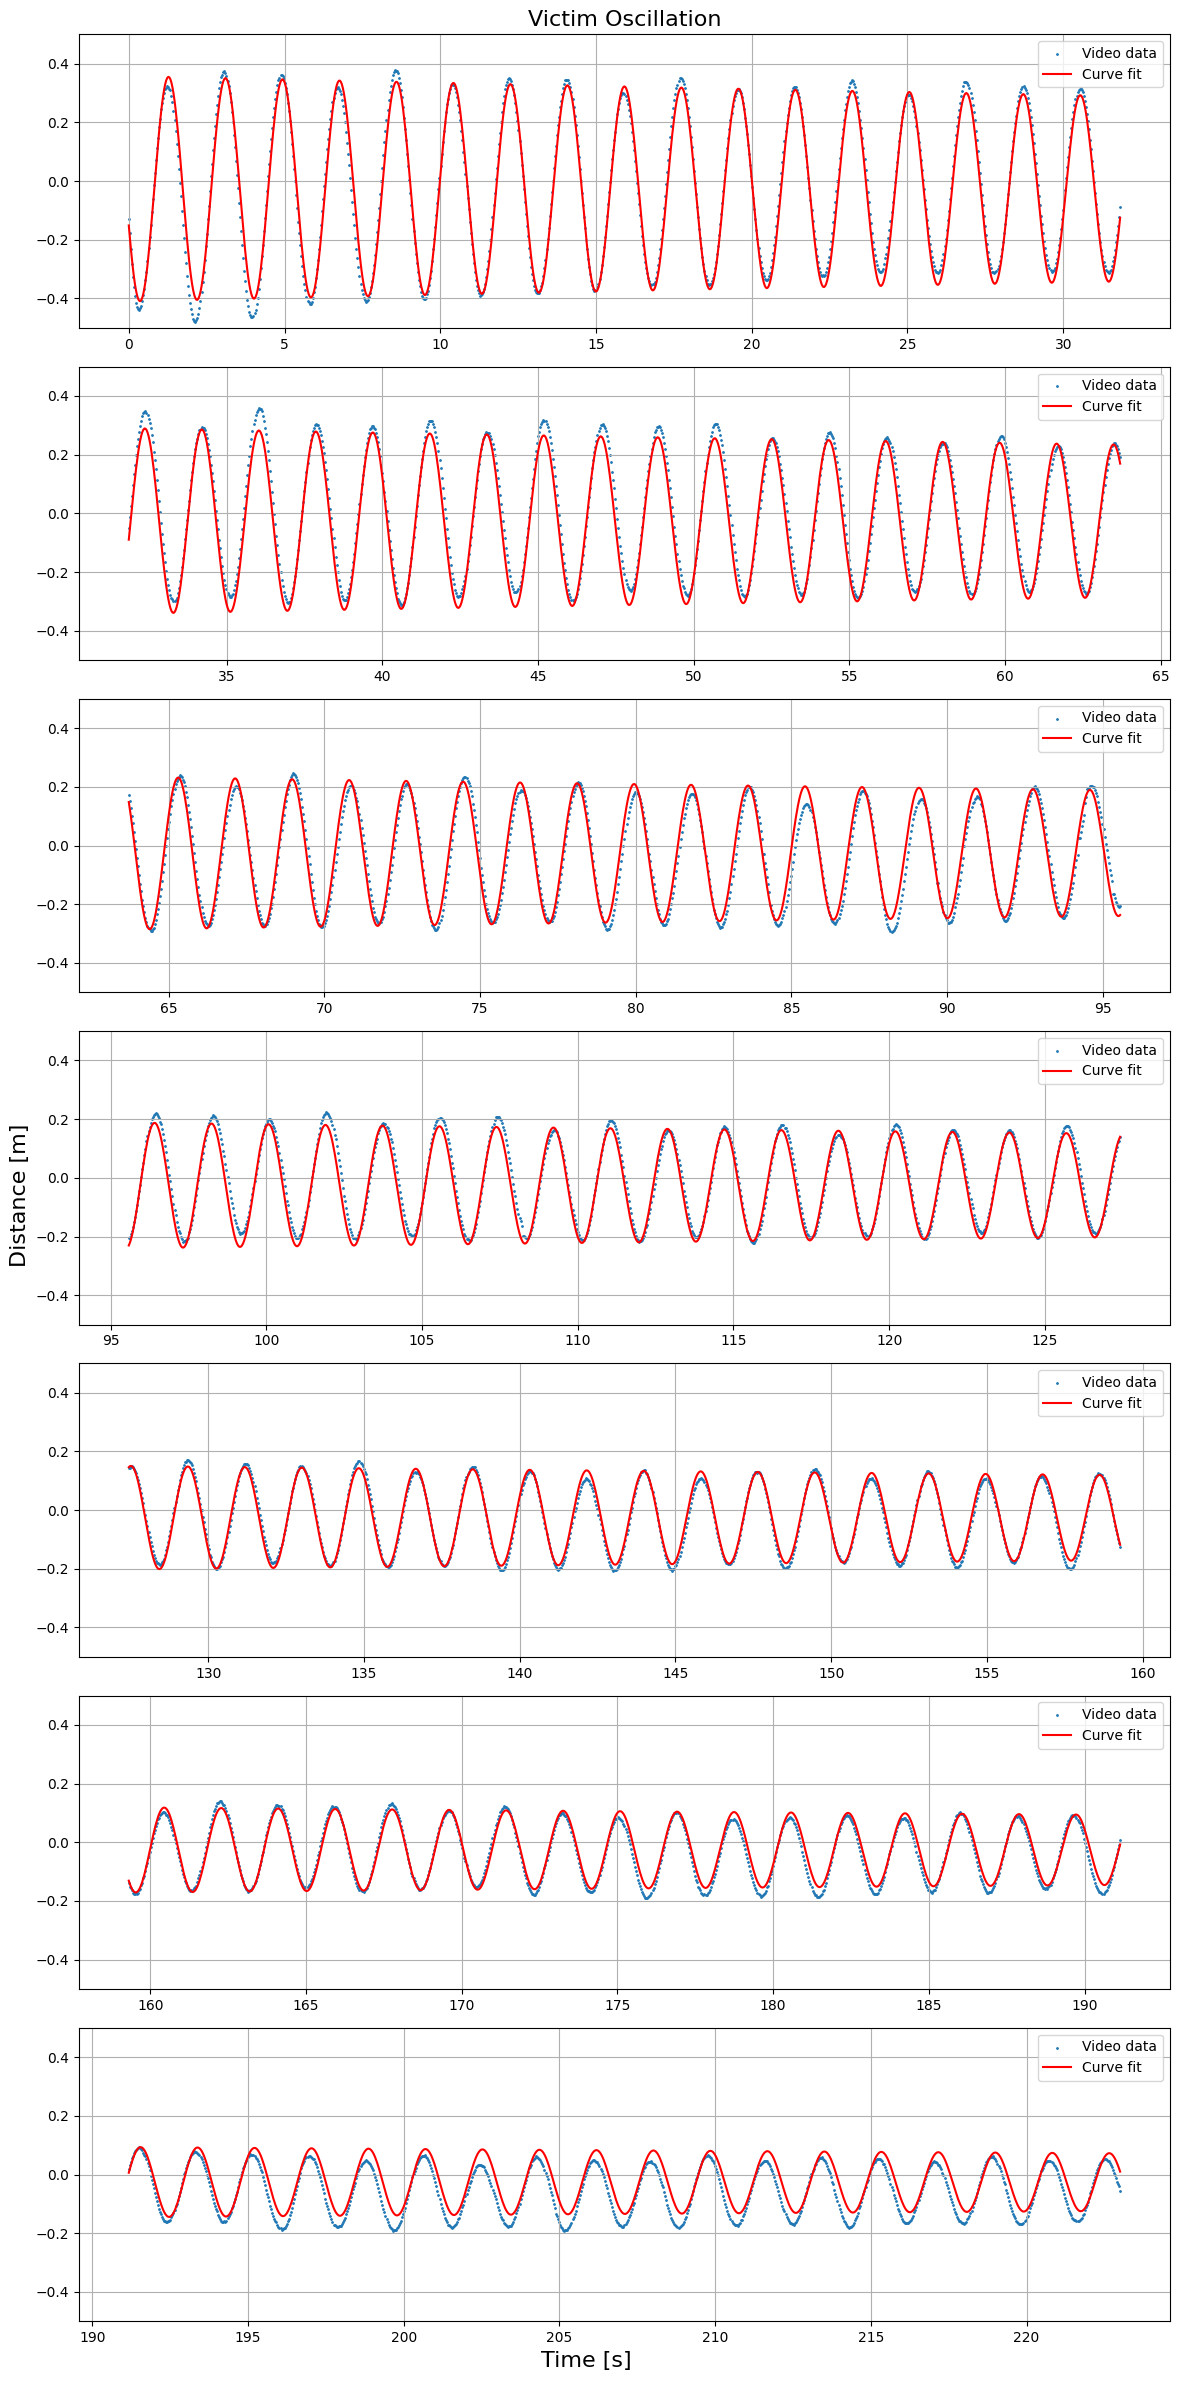

In [12]:
# Stolen from: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-np
# Modified to include lambda for sine curve damping and to use a cosine "sine" curve


def fit(tt: np.ndarray, yy: np.ndarray):
    """
    Fit sin to the input time sequence, and return fitting parameters "amp",
    "omega", "phase", "offset", "freq", "period", "lambda" and "fitfunc"
    """
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(
        ff[np.argmax(Fyy[1:]) + 1]
    )  # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.0**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.0 * np.pi * guess_freq, 0.0, guess_offset, 0.0])

    def sinfunc(t, amp, omega, phase, offset, lambd):
        return amp * np.exp(-t * lambd) * np.cos(omega * t + phase) + offset

    popt, pcov = sp.curve_fit(sinfunc, tt, yy, p0=guess)
    amp, omega, phase, offset, lambd = popt
    freq = omega / (2.0 * pi)
    fitfunc = lambda t: amp * np.exp(-t * lambd) * np.cos(omega * t + phase) + offset

    return {
        "amp": amp,
        "omega": omega,
        "phase": phase,
        "freq": freq,
        "offset": offset,
        "period": 1.0 / freq,
        "lambda": lambd,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov),
    }


# Interpolation
fit_dict = fit(time, distance)

equation = f"{fit_dict['amp']} * exp(-({fit_dict['lambda']}) * t) * cos({fit_dict['omega']} * t + ({fit_dict['phase']})) + ({fit_dict['offset']})"

print(f"The equation of best fit is: {equation}")
print(f"Lambda: {fit_dict['lambda']}")
print(f"Half-life decay: {log(2)/fit_dict['lambda']} seconds") # lambda -> half-life
print(f"Actual period: {fit_dict['period']} seconds")
print(f"Actual frequency: {fit_dict['freq']} Hz")

# Splitting data up to make graphs more readable
time_split = np.split(time, 7)
distance_split = np.split(distance, 7)

# There's really no way I can think of to show the scatter plot and fitted curve
# together well, but I do it this way
fig, axes = plt.subplots(7, figsize=(12, 24))

fig.supxlabel("Time [s]", fontsize=16)
fig.supylabel("Distance [m]", fontsize=16)

for time_part, dist_part, ax in zip(time_split, distance_split, axes):
    ax.scatter(time_part, dist_part, s=1, label="Video data")
    ax.plot(time_part, fit_dict["fitfunc"](time_part), color="red", label="Curve fit")
    ax.set_ylim([-0.5, 0.5])
    ax.legend()
    ax.grid()

axes[0].set_title("Victim Oscillation", fontsize=16)  # Terrible hack

fig.tight_layout()

The above graph shows how well the curve fits our data, but not the graph's
exponential degrowth. Below is a condensed graph which better shows this and the
curve's fit to said degrowth:

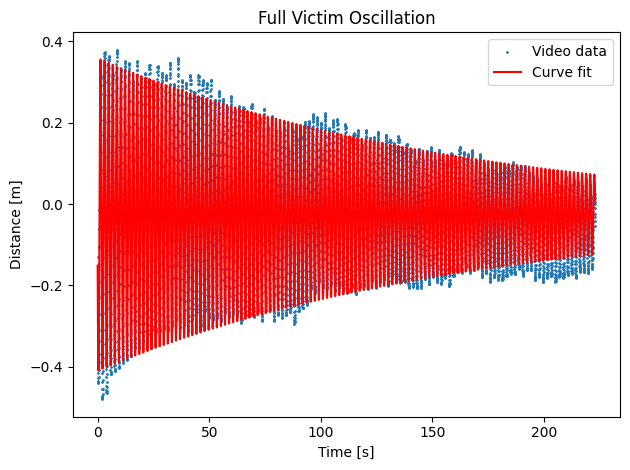

In [13]:
fig, ax = plt.subplots()

ax.scatter(time, distance, s=1, label="Video data")
ax.plot(time, fit_dict["fitfunc"](time), color="red", label="Curve fit")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance [m]")
ax.set_title("Full Victim Oscillation")
ax.legend()

fig.tight_layout()

Going back to our predictions for period and frequency:

In [14]:
diff_period = abs(fit_dict['period'] - period)
diff_freq = abs(fit_dict['freq'] - freq)

print(f"Difference (real vs pred) in period: {diff_period} seconds")
print(f"Difference (real vs pred) in frequency: {diff_freq} seconds")

Difference (real vs pred) in period: 0.020237007244649385 seconds
Difference (real vs pred) in frequency: 0.0059795108973537126 seconds


And next to compare the actual max velocity and accelerations to the predictions:

In [18]:
# Compute derivatives
real_vel = np.gradient(distance, time) # m/s
real_accel = np.gradient(real_vel, time) # m/s^2

real_v_max = max(real_vel)
real_a_max = max(real_accel)

diff_period = abs(real_v_max - v_max)
diff_freq = abs(real_a_max - a_max)

print(f"Real max velocity: {real_v_max} m/s")
print(f"Real max acceleration: {real_a_max} m/s")

print(f"Difference (real vs pred) in max velocity: {diff_period} m/s")
print(f"Difference (real vs pred) in max acceleration: {diff_freq} m/s^2")


Real max velocity: 1.491742515858836 m/s
Real max acceleration: 11.503007399664451 m/s
Difference (real vs pred) in max velocity: 0.03327169825359033 m/s
Difference (real vs pred) in max acceleration: 6.549091622899744 m/s^2


## Analysis

We don't know why the difference between our prediction and the actual max
velocity is so small, whereas the acceleration difference is so big. This is
likely the result of some Numpy issue with `gradient()` or `max()`. Besides
that, our _incredibly precise estimations_ for the period and frequency were
within 20 milliseconds of the actual values (gathered using a Fast Fourier
Transform). Looking at how well the fit curve matches, it is very clear that the
value found for the decay constant, $\lambda = 0.0061$, accurately predicts the
motion of the springs.

# Problem 3

* Find space and set a meter stick in the frame of a camera
* Use a stable camera to capture 20 paces on video
* Measure each stride, take average Measure the period of each stride, take the
  average
* Apply the $f=1/T$ formula to calculate stride
* Repeat for faster walking find difference between each

We plan to find the period of each step by simply timing each step, then finding
the average. The average length of each step can be measured similarly, and each
represents their respective quality starting from the person walking lifts their
foot up, until they set it down again. From here, we can use the formula:

$$ f=\frac{1}{T} $$

to convert the measured average period into frequency, This process is then
repeated with a faster pace. Though this model should provide decent accuracy,
it doesn't account for the knee nor ankle, and therefore only really models the
motion of the upper leg well, When running, the motion of the knee is vastly
more significant, resulting in far less accurate data. As long as the knee is
straight at the end of the motion, this experiment should be decently accurate.



In [16]:
# Slower pace data (iPad)
slow_period = [0.6909, 2.445, 2.445, 4.263, 4.263, 6.209, 6.263, 8.227, 8.227, 10.06, 10.06]  # m
slow_len = [0.5667,1.368,1.935,2.702,3.303, 3.97, 4.57, 5.238, 5.772, 6.438]  # s

# Fast pace data (iPad)
fast_period = [0.4667, 1.002, 1.535, 2.035, 2.502, 3.003, 3.47, 3.97, 4.437, 4.938]  # m
fast_len = [0.4164, 2.397, 2.397, 4.645, 6.81, 6.81, 9.059, 9.077, 11.54]  # s

# Averages
avg_len_slow = np.mean(slow_len)
avg_per_slow = np.mean(slow_period)

avg_len_fast = np.mean(fast_len)
avg_per_fast = np.mean(fast_period)

# Convert period to frequency
freq_slow = 1 / avg_per_slow
freq_fast = 1 / avg_per_fast

dif_freq = freq_fast - freq_slow
dif_len = avg_len_fast - avg_len_slow

print(f"Difference of frequency: {dif_freq} Hz")
print(f"Difference of length: {dif_len} m")

Difference of frequency: 0.19133400186665017 Hz
Difference of length: 2.3194411111111113 m


## Analysis

Our data ended up showing significant impact increases of stride length and
stride frequency at 0.19 Hz and 2.32 m respectively, Though this impact is
likely different from person to person depending on how they learned to walk.
Most people have different ways of achieving the same walk speed, for someone
with longer legs, the impact on frequency may be reduced, where people with
shorter legs will likely compensate with faster paces. In the case of Sarah, it
seems that the distance of her stride was impacted primarily, but both were
impacted significantly.

It's easy to compare this motion to that of a pendulum, even though this fails
to account for the muscle force applied while walking, you can still easily see
oscillation if looking at the Y component of the motion of someone's leg, or
with a frame of reference that moves with the person walking, The motion
oscillating between the points where someone's foot makes or loses contact with
the ground can be modelled as a wave, with the frequency based on the timing, as
demonstrated, and amplitude based on the height to which someone raises their
foot.


# Conclusion

Make note that we wanted to do a lot more with problem 1, like finding the
damping coefficient, so we decided to not do problem 2 to give us more time to
get good data for problem 1.

* * *

These two experiments have proven how harmonic oscillators serve as a
foundational model in physics, offering a clear and powerful framework for
understanding phenomena like mechanical motion, wave behavior, and even energy
transfer. Although a majority of the lab was spent on the collection of over 3
minutes data for experiment one ($n=6685$), we were successful in accurately
finding position, velocity, acceleration, forces, energy, magnitude, maximum
velocity ($v_{max}=1.4$ m/s), maximum acceleration ($a_{max}=11$ m/s), periods
($T=1.829$ s) and related frequencies, and most importantly: confirming the
equilibrium position by the theory of harmonic motion. Our prediction values
were within 20 milliseconds of the actual data! Harmonic oscillators can be
found in the real world such as the shock absorbers found in cars, trucks, and
other vehicles.

